In [1]:
import itertools as itt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import pickle
import scipy.optimize as spo
import scipy.special as spsp
import scipy.stats as sps
import seaborn as sns

from matplotlib.ticker import FixedLocator

mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 'large'

path_proj = os.getcwd()+ '/'
path_sc = path_proj + 'csv/Single_cell/'
path_sort = path_proj + 'csv/Sort/'
path_plot = path_proj + 'figures/'

print(path_proj)

#LOAD AND CLEAN THE DATA
dfr = pd.read_excel(path_proj+'csv/Culture_results.xlsx', sheet_name='Sheet3')#, sep=';', decimal=',')
for k in range(4,dfr.shape[1],3):
    dfr.iloc[:,k:k+3] = dfr.iloc[:,k-3:k].values + dfr.iloc[:,k:k+3].values

dfe = pd.read_excel(path_proj+'csv/Culture_results.xlsx', sheet_name='cloning efficiency_CP')
dfe = dfe.drop(['GMP'], axis=1)

/Users/quanti/Desktop/HSC/Generational_multiplex_analysis_2_backup_copy_20200714/


In [2]:
#PROCESSING
lst_cols = {}
lst_cols_std = {}

for k in range(1,dfr.shape[1],3):
    columns = dfr.columns[k:k+3]
    label = dfr.columns[k][:-1]
    means = dfr.loc[:,columns].mean(axis=1)
    dct_col = {label:means.to_list()}
    dct_col_std = {label:dfr.loc[:,columns].std(axis=1).to_list()}
    lst_cols.update(dct_col)
    lst_cols_std.update(dct_col_std)
df = pd.DataFrame.from_dict(lst_cols)
df.index = dfr.iloc[:,0].to_list()
df_std = pd.DataFrame.from_dict(lst_cols_std)
df_std.index = dfr.iloc[:,0].to_list()
df.columns

Index(['MK', 'CFU-MK', 'GM', 'BFU-E', 'Mixed'], dtype='object')

In [3]:
df_std

,MK,CFU-MK,GM,BFU-E,Mixed
SLAM-HSC,0.000000,1.697056,1.061629,7.284168,2.828427e-08
MPP,1.166364,2.103778,17.677465,17.677465,1.154705e-09
PreMegE,2.546210,6.140517,9.724163,16.169012,2.121318e-09
CMP/MEP,0.352162,0.382001,2.282867,16.419815,2.757715e-08
GMP,0.000000,0.000000,1.786466,4.067456,1.414219e-09


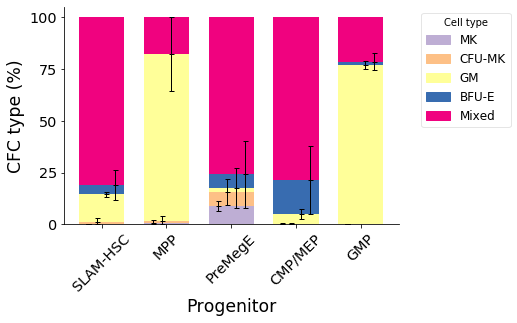

In [4]:
colors = sns.color_palette('Accent')[1:6]
xlabel = 'Progenitor'
ylabel = 'CFC type (%)'
legend_title = 'Cell type'
legend_classes = df.columns.to_list()
legend_cols = colors
cat_width = 0.7
fig, ax = plt.subplots()
n_cat = len(df)
for nc,cat_k in enumerate(df.index):
    x_cat = -cat_width/2 + nc
    y = df.loc[cat_k].values
    ci = df_std.loc[cat_k].values
    bar_width = cat_width
    bottoms = np.hstack([np.zeros(1),y[:-1]])
    x_ci = [x_cat+k*bar_width/(len(y)) for k in np.arange(1,len(y))]
    if len(ci) != 0:
        prev_y = y[0]
        for k in np.arange(len(y)-1):
            if k == 0 or y[k] != prev_y:
                ax.plot([x_ci[k]]*3, [max(y[k]-ci[k], 0), y[k], min(y[k]+ci[k], 100)],
                        ls='-', marker='_', ms=5., lw=1., color='Black')#, color='Silver')
            prev_y = y[k]
    ax.bar(x=[x_cat]*len(y), height=y-bottoms,
           width=[bar_width]*len(y), bottom=bottoms, align='edge',
           color=colors)
handles = [mpatches.Patch(color=co, label=cl) for cl,co in zip(legend_classes,legend_cols)]
ax.legend(handles=handles, loc='upper left', ncol=1, bbox_to_anchor= (1.05, 1.), title=legend_title)

ax.set_xticks(np.arange(n_cat, dtype=int))
ax.set_xticklabels(df.index.to_list(), rotation=45)
ax.set_ylim(bottom=0)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_yticks(np.linspace(0,100,5))
ax.set_yticklabels(np.linspace(0,100,5, dtype=int))
sns.despine(fig=fig)
fig.savefig(path_plot+'FigCFC.pdf', bbox_inches='tight')

In [5]:
dfe

,SLAM-HSC,MPP,PreMegE,CMP/MEP,BM
0,3.00,0.55,1.75,0.250,0.020
1,0.17,0.03,0.50,0.033,0.029
2,0.00,0.00,1.10,0.033,0.026


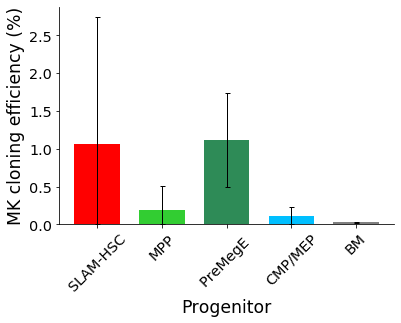

In [6]:
#def plot_bars(dct_plot, cols_dct, xlabel, ylabel,
#              legend_title, legend_classes, legend_cols,
#              cat_width=0.7, str_sep='   '):
#cols_dct
colors = sns.color_palette('Accent')
colors = ['Red', 'Limegreen', 'seagreen', 'Deepskyblue', 'grey']
#             'SLAM+ Flt3+':'seagreen', 'GMP':'aqua', 'MEP':'Deepskyblue', 'SLAM+ MEP':'Royalblue',
#             'MP':'DarkViolet', 'CD16/32- ckit-':'Violet'}
#['MK', 'CFU-MK', 'GM', 'BFU-E', 'Mixed']
xlabel = 'Progenitor'
ylabel = 'MK cloning efficiency (%)'
legend_title = 'Cell type'
legend_classes = df.columns.to_list()
legend_cols = colors
cat_width = 0.7
fig, ax = plt.subplots()

for k,col in enumerate(dfe.columns):
    dfe.loc[:,col]
    x = k - cat_width/2
    y = dfe.loc[:,col].mean()
    ci = dfe.loc[:,col].std()
    ax.plot([k]*2, [max(y-ci, 0), min(y+ci, 100)],
            ls='-', marker='_', ms=5., lw=1., color='Black')#, color='Silver')
    ax.bar(x=x, height=y,
           width=cat_width, bottom=0, align='edge',
           color=colors[k])#, label=col)
#ax.legend(handles=handles, loc='upper left', ncol=1, bbox_to_anchor= (1.05, 1.), title=legend_title)

ax.set_xticks(np.arange(len(dfe.columns), dtype=int))
#xtickslabels = [str_sep.join(dct_plot[cat_k].keys())+'\n'+cat_k for cat_k in dct_plot.keys()]
ax.set_xticklabels(dfe.columns.to_list(), rotation=45)
ax.set_ylim(bottom=0)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_yticks(np.linspace(0,100,5))
#ax.set_yticklabels(np.linspace(0,100,5, dtype=int))
sns.despine(fig=fig)
#return fig,ax
fig.savefig(path_plot+'FigCEFF.pdf', bbox_inches='tight')